<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Word2vec_CBOW_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2vec

[Word2Vec](https://arxiv.org/abs/1301.3781) is a statistical method for efficiently learning a standalone word embedding from a text corpus. It was developed by Google in 2013.

Additionally, the work involved analysis of the learned vectors and the exploration of vector math on the representations of words. The word vectors can be reduced to two-dimensions using a dimensionality reduction technique to explore relationships between certain words.

![](https://i.ibb.co/8dHdyKk/wor2vec-relatiuonships.png)

An interesting tool to visualize these relationships can be seen in a [tensorflow projection](https://projector.tensorflow.org/) where the word vectors are reduced to a three-dimensional space.

The trick is to train a simple neural network with a single hidden layer to perform a certain task, but then we’re not actually going to use that neural network for the task we trained it on! Instead, the goal is actually just to learn the weights of the hidden layer (these weights are actually the *word vectors* that we’re trying to learn).

Two different learning models were introduced that can be used as part of the Word2Vec approach to learn the word embedding:

-  Continuous Bag-of-Words, or CBOW model.
-  Continuous Skip-Gram Model.

In this notebook, we are going to deep into the CBOW model.

## CBOW

The **CBOW** model learns the embedding by predicting the current target word (the center word) based on the context words (its surrounding words).

![](https://i.ibb.co/XbLDFZB/CBOW-word2vec.png)

While the Word2Vec family of models is unsupervised (we just give it a corpus without additional labels and it can construct dense word embeddings from the corpus), we will still need to leverage a supervised, classification methodology once we have this corpus to get these embeddings. Although we can do that from within the corpus itself, without any auxiliary information. We can model this CBOW architecture now as a classification model such that we take in the context words as our input, `X`, and try to predict the target word, `Y`. 

Considering a simple sentence, "deep learning is very hard and fun". If we consider a context window of size 2, we will take 2 words behind the word and 2 words after the word. Hence for each word, we will get 4 words associated with it. We will do this for every word in the data and collect the word pairs. Let’s visualize this.

![](https://i.ibb.co/ggCDLSn/context-and-target-word-word2vec.png)

 

Note that for the words near the edges, we have lesser words to consider and hence the number of context words will be lesser than 4. In the practice, padding is used so that the number of words will be always 4.

As we are passing the context window through the text data, we find all word pairs of target and context words to form a dataset in the format of (*context_window, target_word*). For the sentence above, it will look like this:

- $1^{\text{st}}$ window: (["learning", "is"],"deep")
- $2^{\text{st}}$ window: (["deep", "is", "very"],"learning")
- $3^{\text{st}}$ window: (["deep", "learning", "very", "hard"],"is")

And so on. This can be considered as our "training data" for word2vec.

It should be noted that the order of the input words is not considered in the model (hence the concept of the bag of words in its name).





## Implementing CBOW model

#### Load the required libraries

In [3]:
import numpy as np
import pandas as pd
np.random.seed(13)

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#import gensim

#### Load corpus

In [27]:
path = get_file('alice.txt', origin='http://www.gutenberg.org/files/11/11-0.txt')
corpus = open(path).readlines()
print(f'First 10 sentences of the corpus: {corpus[0:10]}')

First 10 sentences of the corpus: ['\ufeffThe Project Gutenberg EBook of Alice’s Adventures in Wonderland, by Lewis Carroll\n', '\n', 'This eBook is for the use of anyone anywhere at no cost and with\n', 'almost no restrictions whatsoever.  You may copy it, give it away or\n', 're-use it under the terms of the Project Gutenberg License included\n', 'with this eBook or online at www.gutenberg.org\n', '\n', '\n', 'Title: Alice’s Adventures in Wonderland\n', '\n']


#### Build the corpus vocabulary

We will first build our corpus vocabulary where we extract out each unique word from our vocabulary and map a unique numeric identifier to it.

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
corpus_ids = tokenizer.texts_to_sequences(corpus)
word_id_dict = tokenizer.word_index
word_id_dict['PAD'] = 0
id_word_dict = {v:k for k, v in word_id_dict.items()}
print(f'First 10 sentences of the corpus by ids: {corpus_ids[0:10]}')
#number_samples = sum(len(s) for s in corpus_ids)
vocab_size = len(word_id_dict)
print(f'Vocabulary size: {vocab_size}')


First 10 sentences of the corpus by ids: [[1838, 46, 42, 379, 6, 237, 380, 10, 487, 47, 820, 821], [], [22, 379, 34, 24, 1, 147, 6, 699, 996, 19, 49, 822, 3, 18], [488, 49, 1295, 1296, 11, 174, 344, 8, 311, 8, 165, 27], [1297, 147, 8, 203, 1, 204, 6, 1, 46, 42, 259, 997], [18, 22, 379, 27, 823, 19, 408, 42, 381], [], [], [1839, 237, 380, 10, 487], []]
Vocabulary size: 3552


The `PAD` term is typically used to pad context words to a fixed length if needed.

#### Build a CBOW (context, target) generator

We need pairs that consist of a target center word and surround context words. In our implementation, the surrounding context is composed of `2*window_size` words (except for words near the edges) where we take `window_size` words before and after the target word in our corpus. This will become clearer with the following example.

In [6]:
def generate_data(corpus, window_size, vocab_size):
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)

            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            # Convert the target word to one-hot encoding
            y = np_utils.to_categorical(labels, vocab_size)
            yield (x, y)

We define the dimension of the embedding to 100, and the window size to 2.

In [7]:
dim_embedding = 100
window_size = 2

Let's see some examples of training batches: 

In [9]:
# Test this out for some samples
i = 0
for x, y in generate_data(corpus_ids[80:100], window_size, vocab_size):
    if x[0][0] != 0:
        print('_'*60)
        #print('x:', x)
        #print('y:', y)
        print('Context (X):', [id_word_dict[w] for w in x[0]], '-> Target (Y):', id_word_dict[np.argwhere(y[0])[0][0]])
        i+=1
        if i==5:
            break
    

____________________________________________________________
Context (X): ['large', 'rabbit', 'under', 'the'] -> Target (Y): hole
____________________________________________________________
Context (X): ['rabbit', 'hole', 'the', 'hedge'] -> Target (Y): under
____________________________________________________________
Context (X): ['in', 'another', 'down', 'went'] -> Target (Y): moment
____________________________________________________________
Context (X): ['another', 'moment', 'went', 'alice'] -> Target (Y): down
____________________________________________________________
Context (X): ['moment', 'down', 'alice', 'after'] -> Target (Y): went


This output give us more perspective of how `X` forms our context words and we are trying to predict the target center word `Y` based on its context.

#### Build the CBOW model architecture

We now leverage Keras to build our deep learning architecture for the CBOW model. For this, our inputs will be our context words which are passed to an embedding layer (initialized with random weights). The word embeddings are propagated to a lambda layer where we average out the word embeddings (hence called CBOW because we don’t really consider the order or sequence in the context words when averaged) and then we pass this averaged context embedding to a dense softmax layer which predicts our target word. We match this with the actual target word, compute the loss by leveraging the `categorical_crossentropy` loss ([explanatory video](https://www.coursera.org/lecture/probabilistic-models-in-nlp/training-a-cbow-model-cost-function-N1pEX)) and perform backpropagation with each epoch to update the embedding layer in the process. The following code shows us our model architecture.

In [11]:
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=dim_embedding, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim_embedding,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='sgd')
cbow.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            355200    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3552)              358752    
Total params: 713,952
Trainable params: 713,952
Non-trainable params: 0
_________________________________________________________________


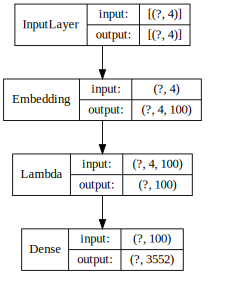

In [12]:
# visualize model structure
SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=65).create(prog='dot', format='svg'))

We have input context words of dimensions ($2 \times \text{window_size}$), we will pass them to an embedding layer of size ($\text{vocab_size}  \times \text{dim_embedding}$) which will give us dense word embeddings for each of these context words ($1 \times \text{dim_embedding}$ for each word). Next up we use a lambda layer to average out these embeddings and get an average dense embedding ($1 \times \text{dim_embedding}$) which is sent to the dense softmax layer which outputs the most likely target word. We compare this with the actual target word, compute the loss, backpropagate the errors to adjust the weights (in the embedding layer), and repeat this process for all (context, target) pairs for multiple epochs. The following figure tries to explain the same.

![](https://i.ibb.co/f4bJF8k/cbow-model.png)



We are now ready to train this model on our corpus using our data generator to feed in (*context, target_word*) pairs (explanatory [video](https://www.coursera.org/lecture/probabilistic-models-in-nlp/training-a-cbow-model-forward-propagation-Vphwi) of the training process).

#### Train the Model

In [14]:
epochs = 1
for epoch in range(epochs):
    loss = 0.
    for x, y in generate_data(corpus_ids, window_size, vocab_size):
        loss += cbow.train_on_batch(x, y)

    print(f'Epoch: {epoch}, loss: {loss}')

Epoch: 0, loss: 224614.19338440895


**Note**: Running this model is computationally expensive and works better if we train it using a GPU.

#### Get Word Embeddings

To get word embeddings for our entire vocabulary, we can extract out the same from our embedding layer ([explanatory video](https://www.coursera.org/lecture/probabilistic-models-in-nlp/extracting-word-embedding-vectors-Py1VW)). We don’t take the embedding at position 0 since it belongs to the padding (`PAD`) term which is not really a word of interest.

In [15]:
vectors = cbow.get_weights()[0]
vectors = vectors[1:]
print(vectors.shape)

pd.DataFrame(vectors, index=list(id_word_dict.values())[1:]).head()


(3551, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
”,-0.029552,-0.128178,-0.071386,-0.059629,-0.140173,-0.123153,-0.035233,-0.160361,-0.063094,0.139186,0.058532,0.134008,0.117726,0.016573,-0.054235,0.121164,0.013266,0.035842,0.214127,0.008796,-0.081649,0.017369,-0.005718,0.001333,-0.041746,0.030866,-0.116763,0.075086,0.121884,0.003918,-0.057648,-0.005558,0.058962,0.018233,0.074702,0.146103,-0.185930,-0.176789,-0.035013,-0.017268,...,0.110904,-0.258919,-0.035852,0.035824,0.007883,0.014758,0.035187,0.133310,0.032935,0.190954,-0.111632,0.045459,0.066904,-0.064270,0.059865,0.158340,-0.010454,0.192761,0.027730,-0.115010,0.040528,-0.159061,0.044026,-0.358830,0.071318,0.039884,0.220668,0.114593,-0.019946,0.040310,0.038064,0.125629,-0.122487,-0.110907,0.188948,-0.005223,-0.053620,0.036097,0.062824,0.012555
and,-0.117233,0.016544,0.101689,0.021456,-0.030479,0.026200,0.008636,-0.126505,0.072622,0.095569,-0.023006,0.008287,0.135392,0.027950,-0.025980,0.109073,0.016646,0.189715,0.135437,0.021837,-0.040788,0.008121,0.093361,-0.048606,0.008493,-0.066345,-0.060154,-0.039572,-0.160502,-0.099071,-0.153187,-0.047099,-0.074506,0.035228,-0.034128,-0.046756,-0.014728,-0.028115,0.033962,-0.020422,...,-0.115893,-0.102126,0.011516,-0.099970,0.036222,0.085219,0.047850,0.063395,-0.089816,0.155253,-0.071693,-0.033219,-0.076548,0.075853,0.032205,0.108184,0.077354,0.106102,0.109509,-0.117673,0.053231,-0.159656,0.043299,-0.057019,0.015827,0.136566,-0.056677,0.136419,0.136370,0.007497,-0.002596,0.084508,-0.080427,0.048260,0.076598,-0.039146,-0.007155,0.028067,-0.002938,0.018143
to,-0.035484,-0.066146,-0.034149,0.007305,0.032073,-0.054643,-0.062519,-0.056999,-0.054246,0.062831,0.003793,0.001459,0.034841,-0.042727,-0.004102,0.057236,0.010382,0.069961,0.020618,0.033784,-0.004615,0.044146,0.035211,-0.008897,-0.033554,0.037463,0.024240,-0.037834,-0.053897,0.019957,0.000546,0.009200,-0.015458,-0.030871,0.014882,-0.022580,-0.024039,0.021216,-0.042906,-0.010084,...,-0.004377,-0.033147,0.002462,-0.027348,0.022194,0.050563,0.048612,-0.015250,-0.006647,0.022340,0.010508,-0.042597,-0.031571,0.035349,0.007185,-0.022979,-0.017612,0.030991,0.013430,0.007389,0.042958,-0.033196,0.044754,-0.038929,0.037473,-0.022918,0.054604,0.040514,0.034267,-0.030979,0.009439,-0.003423,0.005517,0.018388,-0.003103,-0.002675,0.059223,0.029142,-0.043972,-0.007106
a,0.027848,-0.004527,0.046239,0.039621,0.007900,0.007746,0.004744,-0.018295,-0.028796,-0.033999,-0.064780,0.021124,0.022901,-0.062046,0.010096,-0.012618,-0.009146,0.059334,0.043705,0.039751,-0.019967,0.008316,0.018225,0.033478,0.002128,-0.046766,-0.055147,0.005716,0.033384,0.000225,-0.084112,0.020987,-0.048410,-0.003907,-0.020562,0.019196,0.003229,0.011947,-0.045300,0.045124,...,0.028531,0.026697,-0.023553,-0.050060,0.048695,0.063267,-0.012563,0.009970,-0.058870,0.032463,0.003328,-0.015966,-0.039934,-0.032318,-0.004884,0.044362,0.024514,0.057996,0.002856,-0.031226,0.039527,0.015314,0.008797,-0.053099,0.045402,-0.002491,0.024632,0.049172,-0.005550,0.036584,0.006994,0.020529,-0.038625,-0.039016,-0.019945,0.005725,0.026745,0.013703,-0.038166,0.044844
of,-0.012924,-0.087829,-0.035109,-0.028797,0.006452,-0.012191,-0.027451,-0.041174,-0.009586,-0.013946,0.013780,-0.026399,0.021071,-0.054858,0.011236,0.032470,-0.011261,0.040684,0.036073,0.028575,-0.030963,0.040903,0.002826,0.006051,-0.055422,-0.035734,-0.076959,0.047616,-0.024174,-0.017770,0.012372,0.052224,-0.017336,-0.011984,0.058699,0.039830,-0.058143,-0.049876,-0.046568,0.027824,...,0.000640,-0.035797,0.049714,-0.042115,0.030208,0.016677,0.033671,-0.026652,-0.024872,0.065304,-0.035745,0.051818,0.022686,-0.022643,-0.056507,0.058899,-0.036939,0.066628,-0.035605,0.010036,0.013141,-0.019055,0.022245,-0.036076,0.030963,-0.004276,0.072773,-0.006362,0.035447,0.006468,0.025585,-0.021107,0.001213,0.000592,0.019565,

We can see that each word has a dense embedding of size ($1 \times 100$) as depicted in the preceding output. Let’s try and find out some contextually similar words for specific words of interest based on these embeddings. For this, we build out a pairwise distance matrix amongst all the words in our vocabulary based on the dense embedding vectors and then find out the n-nearest neighbors of each word of interest based on the shortest (euclidean) distance.

In [16]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(vectors)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id_word_dict[idx] for idx in distance_matrix[word_id_dict[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['walk', 'surprised', 'slowly', 'remarkable', 'alice']}

similar_words

(3551, 3551)


{'alice': ['cart', 'she', 'is—oh', 'thought', 'mock'],
 'remarkable': ['problem', 'deeply', 'prizes', 'sluggard', 'examining'],
 'slowly': ['paused', 'child', 'cry', 'one—but', 'shaped'],
 'surprised': ['quickly', 'kneel', 'absence', 'late', 'bank—the'],
 'walk': ['began', 'resource', 'dressed', 'editions', 'enough—i']}

We can use Cosine distance to evaluate vector correlations.

![](https://i.ibb.co/C1YxjH2/cosine-similarity.png)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# compute pairwise distance matrix
similarity_matrix = cosine_similarity(vectors)
print(similarity_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id_word_dict[idx] for idx in similarity_matrix[word_id_dict[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['walk', 'surprised', 'slowly', 'remarkable', 'alice']}

similar_words

(3551, 3551)


{'alice': ['remembering', 'teases', 'telescope', 'advise', 'kettle'],
 'remarkable': ['row', 'city', 'improve', 'short', 'nonsense'],
 'slowly': ['“i’m', 'quiet', 'morals', 'procession', '“serpent'],
 'surprised': ['days', 'gloves—that', 'grumbled', 'beheading', 'wildly'],
 'walk': ['b', 'such', 'along—“catch', 'credit', '“first']}

## Subsampling of frequent words and negative sampling 

When we have created the CBOW model for Word2Vec, you may have noticed something. It’s a huge neural network!

Suppose we had word vectors with 300 components and a vocabulary of 10000 words. Recall that the neural network had two weight matrices, a hidden layer, and an output layer. Both of these layers would have a weight matrix with $300 \times 10000 = 3$ million weights each!

Running gradient descent on a neural network that large is going to be slow. And to make matters worse, we need a huge amount of training data to tune that many weights and avoid over-fitting.

The authors of Word2Vec addressed these issues in their second [paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with the following two innovations:

- Subsampling frequent words to decrease the number of training examples.

- Modifying the optimization objective with a technique they called *Negative Sampling*, which causes each training sample to update only a small percentage of the model’s weights.

These techniques not only reduced the compute burden of the training process but also improved the quality of their resulting word vectors as well.

### Subsampling Frequent Words

We have already seen how to create training samples from the source text. We found all word pairs of target and context words to form a dataset in the format of (*context_window, target_word*).

![](https://i.ibb.co/ggCDLSn/context-and-target-word-word2vec.png)



There are two "problems" with common words like "is" or "and":

- When looking at the $5^{\text{st}}$ window (["is", "very", "and", "fun"],"hard"). The words "is" or "and" don’t tell us much about the meaning of “hard” and they appear in the context of pretty much every word.

- We will have many more samples of (“is”,…) than we need to learn a good vector for “is”.

Word2Vec implements a “subsampling” scheme to address this. For each word we encounter in our training text, there is a chance that we will effectively delete it from the text. The probability that we cut the word is related to the word’s frequency.

#### Sampling rate

The word2vec C code implements an equation for calculating a probability with which to keep a given word in the vocabulary.

Given a word $w_i$, we define $z(w_i)$ as the fraction of the total words in the corpus that are that word. For example, if the word "and" occurs 1000 times in a 1 million word corpus, then $z(\text{"and"}) = \frac{1000}{1000000}$. A new parameter, called *sample* controls how much subsampling occurs, and the default value is 0.001. Smaller values of *sample* mean words are less likely to be kept. The probability of keeping the word $w_i$, $P(w_i)$, is given by the equation:

$$P(w_i)=(\sqrt{\frac{z(w_i)}{\text{sample}}}+1)\frac{\text{sample}}{z(w_i)}$$

Thre are some interesting points in this function (we use the default sample value of 0.001).

- $P(w_i)=1.0$  (100% chance of word being kept) when $z(w_i)\leq 0.0026$. This means that only words which represent more than 0.26% of the total words will be subsampled.

- $P(w_i)=0.5$ (50% chance of word being kept) when $z(w_i)=0.00746$.

- $P(w_i)=0.033$ (3.3% chance of being kept) when $z(w_i)=1.0$.
That is, if the corpus consisted entirely of word $w_i$, which is ridiculous.

### Negative sampling

In the word2vec models, each training sample will tweak all of the weights in the neural network.

A big size of our word vocabulary means that our model has a tremendous number of weights, all of which would be updated slightly by every one of training samples! *Negative sampling* addresses this by having each training sample only modify a small percentage of the weights, rather than all of them. 

When training the network on the window (["is", "very", "and", "fun"],"hard"), recall that the "label" or "correct output" of the network is a one-hot vector. That is, for the output neuron corresponding to "hard" to output a 1, and for **all** of the other thousands of output neurons to output a 0.

With negative sampling, we are instead going to randomly select just a small number of "negative" words (let’s say 5) to update the weights for. (In this context, a “negative” word is one for which we want the network to output a 0 for). We will also still update the weights for our "positive" word (which is the word "hard" in our current example).

**Note**: The paper says that selecting 5-20 words works well for smaller datasets, and you can get away with only 2-5 words for large datasets.

If we have a vocabulary size of 10000 words and we use a embedding dimension of 300, the output layer of our model will have a weight matrix that’s $300 \times 10000$. So we will just be updating the weights for our positive word ("hard"), plus the weights for 5 other words that we want to output 0. That’s a total of 6 output neurons, and 1800 weight values total. That’s only 0.06% of the 3M weights in the output layer!

#### Selecting negative samples

The *negative samples* (that is, the 5 output words that we’ll train to output 0) are selected using a *unigram distribution*, where more frequent words are more likely to be selected as negative samples.

For instance, suppose we had our entire training corpus as a list of words, and we chose our 5 negative samples by picking randomly from the list. In this case, the probability for picking a particular word would be equal to the number of times that this word appears in the corpus, divided by the sum of the occurrences of each other words in the corpus. 

$$P(w_i)=\frac{f(w_i)}{\sum_{j=0}^{n}(f(w_j))}$$

The authors state in their paper that they tried several variations on this equation, and the one which performed best was to raise the word counts to the $\frac{3}{4}$ power:

$$P(w_i)=\frac{f(w_i)^{\frac{3}{4}}}{\sum_{j=0}^{n}(f(w_j)^{\frac{3}{4}})}$$

Compared to the simpler equation, this one tends to increase the probability for less frequent words and decrease the probability for more frequent words.



 ## Implementing CBOW model with Gensim

[Gensim](https://github.com/RaRe-Technologies/gensim) is a Python library for topic modeling, document indexing, and similarity retrieval with large corpora. This library provides the `Word2Vec` class for working with a Word2Vec model. Learning a word embedding from text involves loading and organizing the text into sentences and providing them to the constructor of a new `Word2Vec()` instance.

#### Prepare corpus

Each sentence must be tokenized (divided into words). The sentences could be text loaded into memory or an iterator that progressively loads the text, required for very large text corpora. 



In [28]:
print(corpus[0:10])

['\ufeffThe Project Gutenberg EBook of Alice’s Adventures in Wonderland, by Lewis Carroll\n', '\n', 'This eBook is for the use of anyone anywhere at no cost and with\n', 'almost no restrictions whatsoever.  You may copy it, give it away or\n', 're-use it under the terms of the Project Gutenberg License included\n', 'with this eBook or online at www.gutenberg.org\n', '\n', '\n', 'Title: Alice’s Adventures in Wonderland\n', '\n']


In [29]:
sentences = [sentence.split() for sentence in corpus]
print(sentences[0:10])

[['\ufeffThe', 'Project', 'Gutenberg', 'EBook', 'of', 'Alice’s', 'Adventures', 'in', 'Wonderland,', 'by', 'Lewis', 'Carroll'], [], ['This', 'eBook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with'], ['almost', 'no', 'restrictions', 'whatsoever.', 'You', 'may', 'copy', 'it,', 'give', 'it', 'away', 'or'], ['re-use', 'it', 'under', 'the', 'terms', 'of', 'the', 'Project', 'Gutenberg', 'License', 'included'], ['with', 'this', 'eBook', 'or', 'online', 'at', 'www.gutenberg.org'], [], [], ['Title:', 'Alice’s', 'Adventures', 'in', 'Wonderland'], []]


#### Training the model

We prefer to separate the training process in 3 distinctive steps for clarity and monitoring:

1-  `Word2Vec()`: In this first step, we set up the parameters of the model one-by-one.
We do not supply the sentences, and therefore leave the model uninitialized, purposefully. There are many parameters on this constructor:

- `size`: (default 100) The number of dimensions of the embedding, that is the length of the dense vector to represent each token (word).

- `window`: (default 5) The maximum distance between a target word and words around the target word.

- `min_count`: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.

- `negative`: If > 0, negative sampling will be used, the integer value specifies how many "noise words" should be drown. If set to 0, no negative sampling is used.

- `sample`: (default 1e-5) The threshold for configuring which higher-frequency words are randomly downsampled.

- `workers`: (default 3) The number of threads to use while training.

- `sg`: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip-gram (1).

- `alpha`: The initial learning rate.

- `min_alpha`: Learning rate will linearly drop to min_alpha as training progresses.

2- `.build_vocab()`: It builds the vocabulary from a sequence of sentences and thus initialized the model. With the loggings, we can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. These two parameters, and in particular `sample`, have a great influence over the performance of a model. Displaying both allows for more accurate and easier management of their influence.

3.- `.train()`: Finally, trains the model. The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously. The parameters of the training are:
- `total_examples`: Count of sentences.
- `epochs`: Number of iterations (epochs) over the corpus.

In [7]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [8]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

We build the vocabulary.

In [9]:
from time import time

t = time()

w2v_model.build_vocab(sentences, progress_per=100)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


We can print the vocabulary of tokens (words):

In [10]:
words = list(w2v_model.wv.vocab)
print(words)
len(words)

['Project', 'Gutenberg', 'of', 'in', 'by', 'This', 'is', 'for', 'the', 'use', 'at', 'no', 'and', 'with', 'may', 'it,', 'it', 'or', 'under', 'terms', 'this', 'set', 'CHAPTER', 'The', 'a', 'Rabbit', 'from', 'Mock', 'Alice', 'was', 'to', 'get', 'very', 'her', 'on', 'nothing', 'she', 'had', 'into', 'but', '“and', 'what', 'thought', 'So', 'well', 'as', 'made', 'would', 'be', 'getting', 'up', 'when', 'White', 'There', 'so', 'did', 'think', 'much', 'out', 'way', 'say', 'I', 'shall', 'over', 'that', 'have', 'time', 'all', 'seemed', 'quite', 'its', 'looked', 'then', 'on,', 'never', 'before', 'after', 'just', 'see', 'down', 'large', 'another', 'moment', 'went', 'how', 'like', 'some', 'not', 'about', 'herself', 'found', 'look', 'going', 'make', 'too', 'they', 'were', 'there', 'upon', 'She', 'took', 'one', 'great', 'put', 'herself,', 'such', 'me', 'if', 'off', 'come', 'an', '“I', 'I’ve', 'said', 'must', 'you', 'things', 'good', 'right', 'got', 'began', 'their', 'rather', 'them', 'could', 'little',

201

We train the model.

In [11]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.01 mins


#### Exploring the model

As we do not plan to train the model any further, we are calling `init_sims()`, which will make the model much more memory-efficient:

In [12]:
w2v_model.init_sims(replace=True)

Here, we will ask our model to find the word most similar to some words.

In [13]:
w2v_model.wv.most_similar(positive=["Alice"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('moment', 0.9998019933700562),
 ('think', 0.9997971057891846),
 ('So', 0.9997895956039429),
 ('added', 0.9997886419296265),
 ('on', 0.9997850656509399),
 ('got', 0.9997814893722534),
 ('heard', 0.9997798204421997),
 ('them', 0.9997791051864624),
 ('into', 0.9997789263725281),
 ('said,', 0.9997769594192505)]

We can see how similar are two words to each other:

In [14]:
w2v_model.wv.similarity("the", 'for')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99965125

We can review the embedded vector for a specific token as follows:

In [15]:
print(w2v_model['the'])

[ 0.21375056  0.16120857 -0.11373315  0.11415086  0.06541886 -0.07892276
 -0.06338476  0.1286254  -0.00990151 -0.12290736  0.16195273  0.00729052
  0.09874725 -0.20527722 -0.12823749  0.05746158 -0.05147931 -0.15502775
  0.03582692  0.06739356  0.02578196 -0.16577996 -0.01026801  0.01780486
  0.01364862  0.03532826 -0.09602528  0.20533538 -0.17952584 -0.0897965
 -0.10752189  0.11784374 -0.01617444 -0.0311919  -0.09223859 -0.06196856
  0.00785304  0.0197102  -0.04045342 -0.10091233  0.12190437  0.09393188
 -0.07813845 -0.07392438  0.05129271  0.04714946  0.01501277  0.04121938
 -0.17472431  0.14947602 -0.12645413 -0.00199613 -0.01401774 -0.14616165
 -0.05297752 -0.07084643  0.11410096  0.01783177  0.01221659  0.00405719
  0.18528333  0.1244683   0.09965014 -0.02793783  0.01055666 -0.06053714
  0.12303355  0.08367602  0.02736081  0.12617749 -0.02532187 -0.05227293
  0.09856843  0.11244963 -0.13938023 -0.12979284 -0.16459724 -0.00673519
  0.0708756  -0.11254862 -0.09267356 -0.14684954  0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


#### Save the model

Finally, a trained model can then be saved to file by calling the `save_word2vec_format()` function on the word vector model. By default, the model is saved in a binary format to save space.

In [16]:
w2v_model.wv.save_word2vec_format('model.bin')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


When getting started, we can save the learned model in ASCII format and review the contents. We can do this by setting `binary=False` when calling the `save_word2vec_format()` function.

In [31]:
w2v_model.wv.save_word2vec_format('model.txt', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


The saved model can then be loaded.

In [18]:
from gensim.models import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format('/content/model.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


We can see that with a little work to prepare your text document, you can create your own word embedding very easily with Gensim.

## Load Google’s Word2Vec Embedding

Training our own word vectors may be the best approach for a given NLP problem. But it can take a long time, a fast computer with a lot of RAM and disk space, and perhaps some expertise in finessing the input data and training algorithm. An alternative is to simply use an existing pre-trained word embedding. 

Along with the paper and code for Word2Vec, Google also published a pre-trained Word2Vec model on the Word2Vec Google Code Project.
A pre-trained model is nothing more than a file containing tokens and their associated word vectors. The pre-trained Google Word2Vec model was trained on Google news data (about 100 billion words); it contains 3 million words and phrases and was fit using 300-dimensional word vectors. It is a 1.53 Gigabyte file. You can download it from [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing):

In [20]:
from gensim.models import KeyedVectors

filename = '/content/drive/My Drive/GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**Note**: This example may require a workstation with 8 or more Gigabytes of RAM to execute.

An interesting thing that you can do is do a little linear algebra arithmetic with words. For example, a popular example
described in lectures and introduction papers is:

$$\text{queen} = (king - man) + woman$$

That is the word "queen" is the closest word given the subtraction of the notion of "man" from "king" and adding the word "woman". The man-ness in "king" is replaced with woman-ness to give us "queen". A very cool concept. Gensim provides an interface for performing these types of operations in the `most_similar()` function on the trained or loaded model. For example:

In [24]:
result = model.most_similar(positive=['woman','king'],
                            negative=['man'], topn=1)
print(result)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.7118192911148071)]


# References


- [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)

- [Distributed Representations of Words and Phrases
and their Compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

- https://github.com/nzw0301/keras-examples/blob/master/CBoW.ipynb

- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

- https://www.coursera.org/lecture/probabilistic-models-in-nlp/overview-4k0An

- https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-cbow.html

- http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/

- Deep Learning for Natural Language Processing, Jason Brownlee